In [95]:
%%time
# What version of Python do you have?
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from skimage import io, color, transform, feature, data, exposure, filters
from skimage.feature import hog
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split


import matplotlib
matplotlib.use("Agg")

import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix, hstack
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.regularizers import l2
import itertools
import shutil
import random
import glob
from imutils import paths
import argparse
import cv2
import os


print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

%matplotlib inline

io.use_plugin('matplotlib')

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Pandas 1.1.3
Scikit-Learn 0.23.2
GPU is NOT AVAILABLE
Wall time: 10 ms


## from A2, tf 2.0

From https://www.youtube.com/watch?v=qFJeN9V1ZsI,
some components of this code is necessary even for pre-trained CNN.

In [4]:
cc_path = '/Users/Charles/Desktop/ML/A3/img_small/' # file path for cropped images for training
ll_file = '/Users/Charles/Desktop/ML/A3/cluster_images.csv' # file path and file name for csv with labels

os.chdir(cc_path)
# if folders don't exist, make folders
if os.path.isdir('Art') is False:
    print('NO')
    

In [6]:
# https://www.youtube.com/watch?v=qFJeN9V1ZsI

# this cell is useless, just need to be sure that directory is pointed correctly from prev. code
cc_path = '/Users/Charles/Desktop/ML/A3/img_small/' # file path for cropped images for training ll_file = '/Users/ChantsTheRapper/Desktop/ML/A3/cluster_images.csv' # file path and file name for csv with labels

os.chdir(cc_path)

os.chdir('../../')

In [7]:
%%time
train_path = '/Users/Charles/Desktop/ML/A2/dump_folder/cropped_images/train'
valid_path = '/Users/Charles/Desktop/ML/A2/dump_folder/cropped_images/valid'
test_path = '/Users/Charles/Desktop/ML/A3/img_small/'

Wall time: 0 ns


In [8]:
%%time
# https://www.youtube.com/watch?v=qFJeN9V1ZsI

# pre-processing
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(60, 140), classes=['FALSE', 'TRUE'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(60, 140), classes=['FALSE', 'TRUE'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(60, 140), batch_size=10, shuffle=False)

Found 6758 images belonging to 2 classes.
Found 914 images belonging to 2 classes.
Found 404 images belonging to 1 classes.
Wall time: 541 ms


In [ ]:
# grab a batch from training, processing every ten images and corresponding labels
imgs, labels = next(train_batches)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# %%time
# plotImages(imgs)
# print(labels)

In [ ]:
# test set
# test_imgs, test_labels = next(test_batches)
# plotImages(test_imgs)
# print(test_labels)

## CNN 1.0

In [6]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
model = Sequential()
# add layer to the last
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [8]:
# irrelevant
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [ ]:
# irrelevant
params = count_params(model)
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 134260544

In [11]:
# what does this cell do?
for layer in model.layers:
    layer.trainable = False

In [12]:
# what if I don't want to train any further
model.add(Dense(units=0, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
params = count_params(model)
assert params['non_trainable_params'] == 134260544
assert params['trainable_params'] == 8194

## Training VGG16 model

This might not be strictly necessary because I want to use the established weights of the ImageNet set.

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

In [ ]:
assert model.history.history.get('accuracy')[-1] >0.95

## Getting weights from pre-trained CNN

https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
This is an exercise in trying to get the feature maps of the individual layers of a pre-trained CNN (this one trained on about 1000 categories in a famous dataset called Imagenet).  In acquiring the existing weights of this complex model trained on many everyday objects, the hope is that some of the more advanced layers in the CNN may be useful in clustering the high level features of our test set, the art pieces.

In [7]:
filters, biases = model.layers[1].get_weights()
print(filters)

[[[[ 4.29470569e-01  1.17273867e-01  3.40129584e-02 ... -1.32241577e-01
    -5.33475243e-02  7.57738389e-03]
   [ 5.50379455e-01  2.08774377e-02  9.88311544e-02 ... -8.48205537e-02
    -5.11389151e-02  3.74943428e-02]
   [ 4.80015397e-01 -1.72696680e-01  3.75577137e-02 ... -1.27135560e-01
    -5.02991639e-02  3.48965675e-02]]

  [[ 3.73466998e-01  1.62062630e-01  1.70863140e-03 ... -1.48207128e-01
    -2.35300660e-01 -6.30356818e-02]
   [ 4.40074533e-01  4.73412387e-02  5.13819456e-02 ... -9.88498852e-02
    -2.96195745e-01 -7.04357103e-02]
   [ 4.08547401e-01 -1.70375049e-01 -4.96297423e-03 ... -1.22360572e-01
    -2.76450396e-01 -3.90796512e-02]]

  [[-6.13601133e-02  1.35693997e-01 -1.15694344e-01 ... -1.40158370e-01
    -3.77666801e-01 -3.00509870e-01]
   [-8.13870355e-02  4.18543853e-02 -1.01763301e-01 ... -9.43124294e-02
    -5.05662560e-01 -3.83694321e-01]
   [-6.51455522e-02 -1.54351532e-01 -1.38038069e-01 ... -1.29404560e-01
    -4.62243795e-01 -3.23985279e-01]]]


 [[[ 2.7476

In [8]:
# normalize weights
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print(filters)

[[[[0.8601116  0.6161919  0.55114007 ... 0.4212452  0.4828852
    0.5304859 ]
   [0.9545779  0.5408773  0.6017826  ... 0.4582953  0.4846108
    0.5538601 ]
   [0.89960235 0.3896376  0.5539096  ... 0.42523453 0.4852669
    0.5518304 ]]

  [[0.81635594 0.65118545 0.52590066 ... 0.4087713  0.340725
    0.47531587]
   [0.8683965  0.5615535  0.5647105  ... 0.44733417 0.2931476
    0.46953422]
   [0.8437643  0.39145148 0.5206881  ... 0.42896524 0.30857468
    0.4940327 ]]

  [[0.47662497 0.63058364 0.43417358 ... 0.4150598  0.22949417
    0.28977698]
   [0.4609779  0.5572666  0.4450579  ... 0.4508793  0.12949093
    0.22478487]
   [0.4736674  0.40397066 0.41671643 ... 0.42346177 0.16341406
    0.27143562]]]


 [[[0.7392438  0.6404719  0.6507926  ... 0.43525034 0.810127
    0.7901605 ]
   [0.7946921  0.5488246  0.7126644  ... 0.4703888  0.86608565
    0.84737706]
   [0.767142   0.37799242 0.65472686 ... 0.44734278 0.84025717
    0.8312743 ]]

  [[0.55478704 0.6826218  0.6467724  ... 0.4839310

In [9]:
# summarize feature map size for each conv layer
from tensorflow.keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
model = VGG16()
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [14]:
# https://auth0.com/blog/image-processing-in-python-with-pillow/#Resizing-Images
from PIL import Image

a = Image.open('/Users/Charles/Desktop/ML/A3/img_small/Art/2_small.jpg')
new_a = a.resize((224, 224))
new_a.save('image_224.jpg')

# print(image.size) # Output: (1920, 1280)
# print(new_image.size) # Output: (400, 400)

In [15]:
%%time

# plot feature map of first conv layer for given image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = load_img(new_a, target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
# for fmap in feature_maps:
#     # plot all 64 maps in 8x8 squares
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

ResourceExhaustedError: OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: fc1_7/kernel/Initializer/random_uniform/

## Predicting using VGG16 model

What would I predict if I'm not doing classification?

In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [ ]:
predictions = model.predict(x=test_batches, verbose=0)

In [ ]:
test_batches.classes

## MobileNet

MobileNet requires far less memory resources than VGG16 but ranks lower in accuracy as tradeoff.  However, in this clustering task, accuracy is not really a concern so MobileNet may be optimal.

from yt keras with Tensorflow course - Deeplizard

In [2]:
# for GPU, ONLY CHANTSTHERAPPER COMPUTER HAS GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Numb GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Numb GPUs Available:  1


In [3]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 12s 1us/step


In [4]:
def prepare_image(file):
    img_path = '/Users/Charles/Desktop/ML/A3/img_small/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims) # this function resizes image

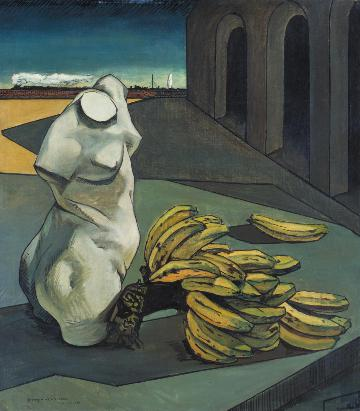

In [5]:
from IPython.display import Image
Image(filename='/Users/Charles/Desktop/ML/A3/img_small/2_small.jpg', width=360, height=411)

In [7]:
preprocessed_image = prepare_image('2_small.jpg')
predictions = mobile.predict(preprocessed_image) # use mobilenet model to make prediction
results = imagenet_utils.decode_predictions(predictions) # function takes image prediction, translates to symbolic language, 
# (c) returns top 5 predictions classifications
results

40960/35363 [==================================] - 0s 2us/step


[[('n06596364', 'comic_book', 0.15882866),
  ('n03888257', 'parachute', 0.090776004),
  ('n07248320', 'book_jacket', 0.07397211),
  ('n04229816', 'ski_mask', 0.068702996),
  ('n01978287', 'Dungeness_crab', 0.058248285)]]

## Resnet50 clustering

https://towardsdatascience.com/image-clustering-using-transfer-learning-df5862779571


In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
resnet_weights_path = '/Users/Charles/Desktop/ML/A3/Resnet50_exp/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

my_new_model = Sequential()
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))

my_new_model.layers[0].trainable = False

### Add metadata features

In [96]:
fpn_csv = '/Users/Charles/Desktop/ML/A3/cluster_images.csv'
data = pd.read_csv(fpn_csv, encoding='ISO-8859-1')

In [97]:
# get column names
list(data)

['s_no',
 'artist',
 'title',
 'art_movement',
 'museum_venue',
 'country_of_origin',
 'has_text',
 'primary_medium',
 'medium',
 'work_size',
 'date',
 'representation',
 'representation_semi',
 'kinetic',
 'map',
 'map2',
 'spatial_dimension',
 'spatial_dimension2',
 'pl',
 'si',
 'va',
 'te',
 'co',
 'or',
 'sh',
 'reflection',
 'po',
 'li',
 'ar',
 'notes']

In [90]:
data.head()

,s_no,artist,title,art_movement,museum_venue,country_of_origin,has_text,primary_medium,medium,work_size,...,va,te,co,or,sh,reflection,po,li,ar,notes
0,2,Giorgio de Chirico,The Uncertainty of the Poet,surrealism,Tate,Italy,False,painting,"painting, oil on canvas",106 x 94 cm,...,3,0,0,4,3,False,0,0,5,"distorted perspective, shadow, signification o..."
1,3,Giovanni Anselmo,Direction,arte povera,Tate,Italy,False,sculpture,"sculpture, fabric, glass & metal",24 x 420 x 335 cm,...,1,3,0,3,2,False,0,0,5,"hard to understand the viewpoint, sense of for..."
2,4,Milton Avery,Yellow Sky,modernism,Tate,America,False,painting,"painting, oil on canvas",156 x 184 cm,...,2,4,4,2,4,False,0,0,5,"flatish, textured shapes & specific colors-lin..."
3,5,Gillian Avery,Distillation,abstraction,Tate,UK,False,painting,"painting, oil, household paint on hardboard",213 x 152 cm,...,1,2,0,2,4,False,0,0,5,"shapes, layers, paint handlng/texture, orienta..."
4,6,Joseph (Jef) Banc,Pair-Bearing Matrix,abstraction,Tate,France,False,painting,"painting, mixed media on canvas",73 x 60 cm,...,1,4,1,0,4,False,0,0,5,"ambiguity through abstraction, odd shape, v te..."


In [138]:
## replace missing values with 0
data['representation'] = data['representation'].replace(np.nan, 0)
data['primary_medium'] = data['primary_medium'].replace(np.nan, 0)
data['art_movement'] = data['art_movement'].replace(np.nan, 0)

## transform primary medium and art movement into numerical keys
art_movement_list = data['art_movement'].to_list()
primary_medium_list = data['primary_medium'].to_list()

movement_list = list()
medium_list = list()

for item in art_movement_list:
    if item not in movement_list:
        movement_list.append(item)

for item in primary_medium_list:
    if item not in medium_list:
        medium_list.append(item)
        
rows = data.shape[0]

for i in range(0, rows ):
    movement = data['art_movement'].values[i]
    medium = data['primary_medium'].values[i]
    movement_index = movement_list.index(movement)
    medium_index = medium_list.index(medium)
    data['art_movement'].values[i] = movement_index
    data['primary_medium'].values[i] = medium_index

    
# X = data[['art_movement', 'representation', 'kinetic', 'spatial_dimension', 'map', 'pl', 'si', 'va', 'te', 'co', 'or', 'sh', 'po', 'li', 'ar']]
X = data[['representation', 'va', 'te', 'or', 'sh', 'po', 'li', 'ar']]

In [120]:
# data['art_movement'] = pd.Categorical(data['art_movement'])
# T = data['art_movement'].cat.codes
# T.head

# X = data[['representation', 'va', 'te', 'co', 'sh']]

In [139]:
X.head()

,representation,va,te,or,sh,po,li,ar
0,True,3,0,4,3,0,0,5
1,True,1,3,3,2,0,0,5
2,True,2,4,2,4,0,0,5
3,False,1,2,2,4,0,0,5
4,False,1,4,0,4,0,0,5


In [122]:
# a function to load all images, resize images into the fixed pixel aspect, pass thru model and extract feature set

def extract_vector(path):
    feature_list = []
    
    for im in glob.glob(path):
        
        im = cv2.imread(im)
        im = cv2.resize(im, (224, 224))
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
        resnet_feature = my_new_model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
        feature_list.append(resnet_feature_np.flatten())
    
    X_concat = np.concatenate([feature_list, X], axis=1)
    
    X_feat = np.array(X_concat)
    return X_feat

In [62]:
X2 = extract_vector('/Users/Charles/Desktop/ML/A3/img_small/*.jpg')

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x0000020A9DD0C5E8>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow_core\python\data\ops\iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow_core\python\ops\gen_dataset_ops.py", line 1138, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


In [34]:
print(X2[0])

[0.31685444712638855 0.998833417892456 0.48838818073272705 ... 0 0 3]


In [35]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=10, random_state=0).fit(X2)
print(km.labels_)

[1 5 3 6 1 1 4 6 7 7 8 3 7 6 9 2 0 4 3 0 1 6 3 7 6 3 7 7 6 1 2 2 9 5 0 6 0
 2 3 0 3 7 5 7 2 9 6 9 2 0 2 6 9 5 9 2 7 7 7 8 0 5 0 7 1 6 1 8 4 6 9 5 1 2
 6 6 6 2 1 0 0 1 2 7 8 0 8 2 8 8 1 8 9 0 3 1 4 9 0 1 1 7 9 7 4 5 1 7 6 4 9
 2 8 9 3 1 3 4 5 5 1 6 2 4 6 5 2 7 1 5 5 1 0 9 9 6 1 9 2 1 2 9 1 9 2 3 7 1
 3 7 7 1 2 4 3 0 2 2 7 2 0 2 1 0 3 9 1 5 8 1 9 1 2 0 6 0 9 8 5 6 1 0 1 4 6
 1 6 2 1 2 2 9 6 0 2 0 8 0 6 4 8 8 7 5 5 2 2 8 6 5 4 8 8 2 6 8 5 5 5 4 1 5
 2 2 2 3 8 4 4 8 7 9 8 5 0 5 8 8 0 8 8 6 6 0 0 5 6 5 4 9 9 4 0 6 0 8 8 6 5
 2 0 6 0 0 7 0 8 0 1 8 0 5 8 0 9 1 1 7 9 8 9 3 7 2 5 4 0 7 1 6 0 2 4 1 4 0
 7 1 8 3 3 2 5 8 5 2 1 7 0 8 5 1 7 4 6 5 6 7 1 9 4 8 9 5 0 5 2 6 2 2 3 1 4
 5 8 1 9 3 9 1 1 1 5 3 7 5 1 1 1 1 3 9 2 6 5 5 1 9 5 2 9 8 0 6 1 3 9 0 6 1
 2 1 2 1 5 6 2 1 5 0 6 0 5 0 1 9 4 4 1 0 7 0 1 9 6 9 6 9 6 2 6 6 0 5]


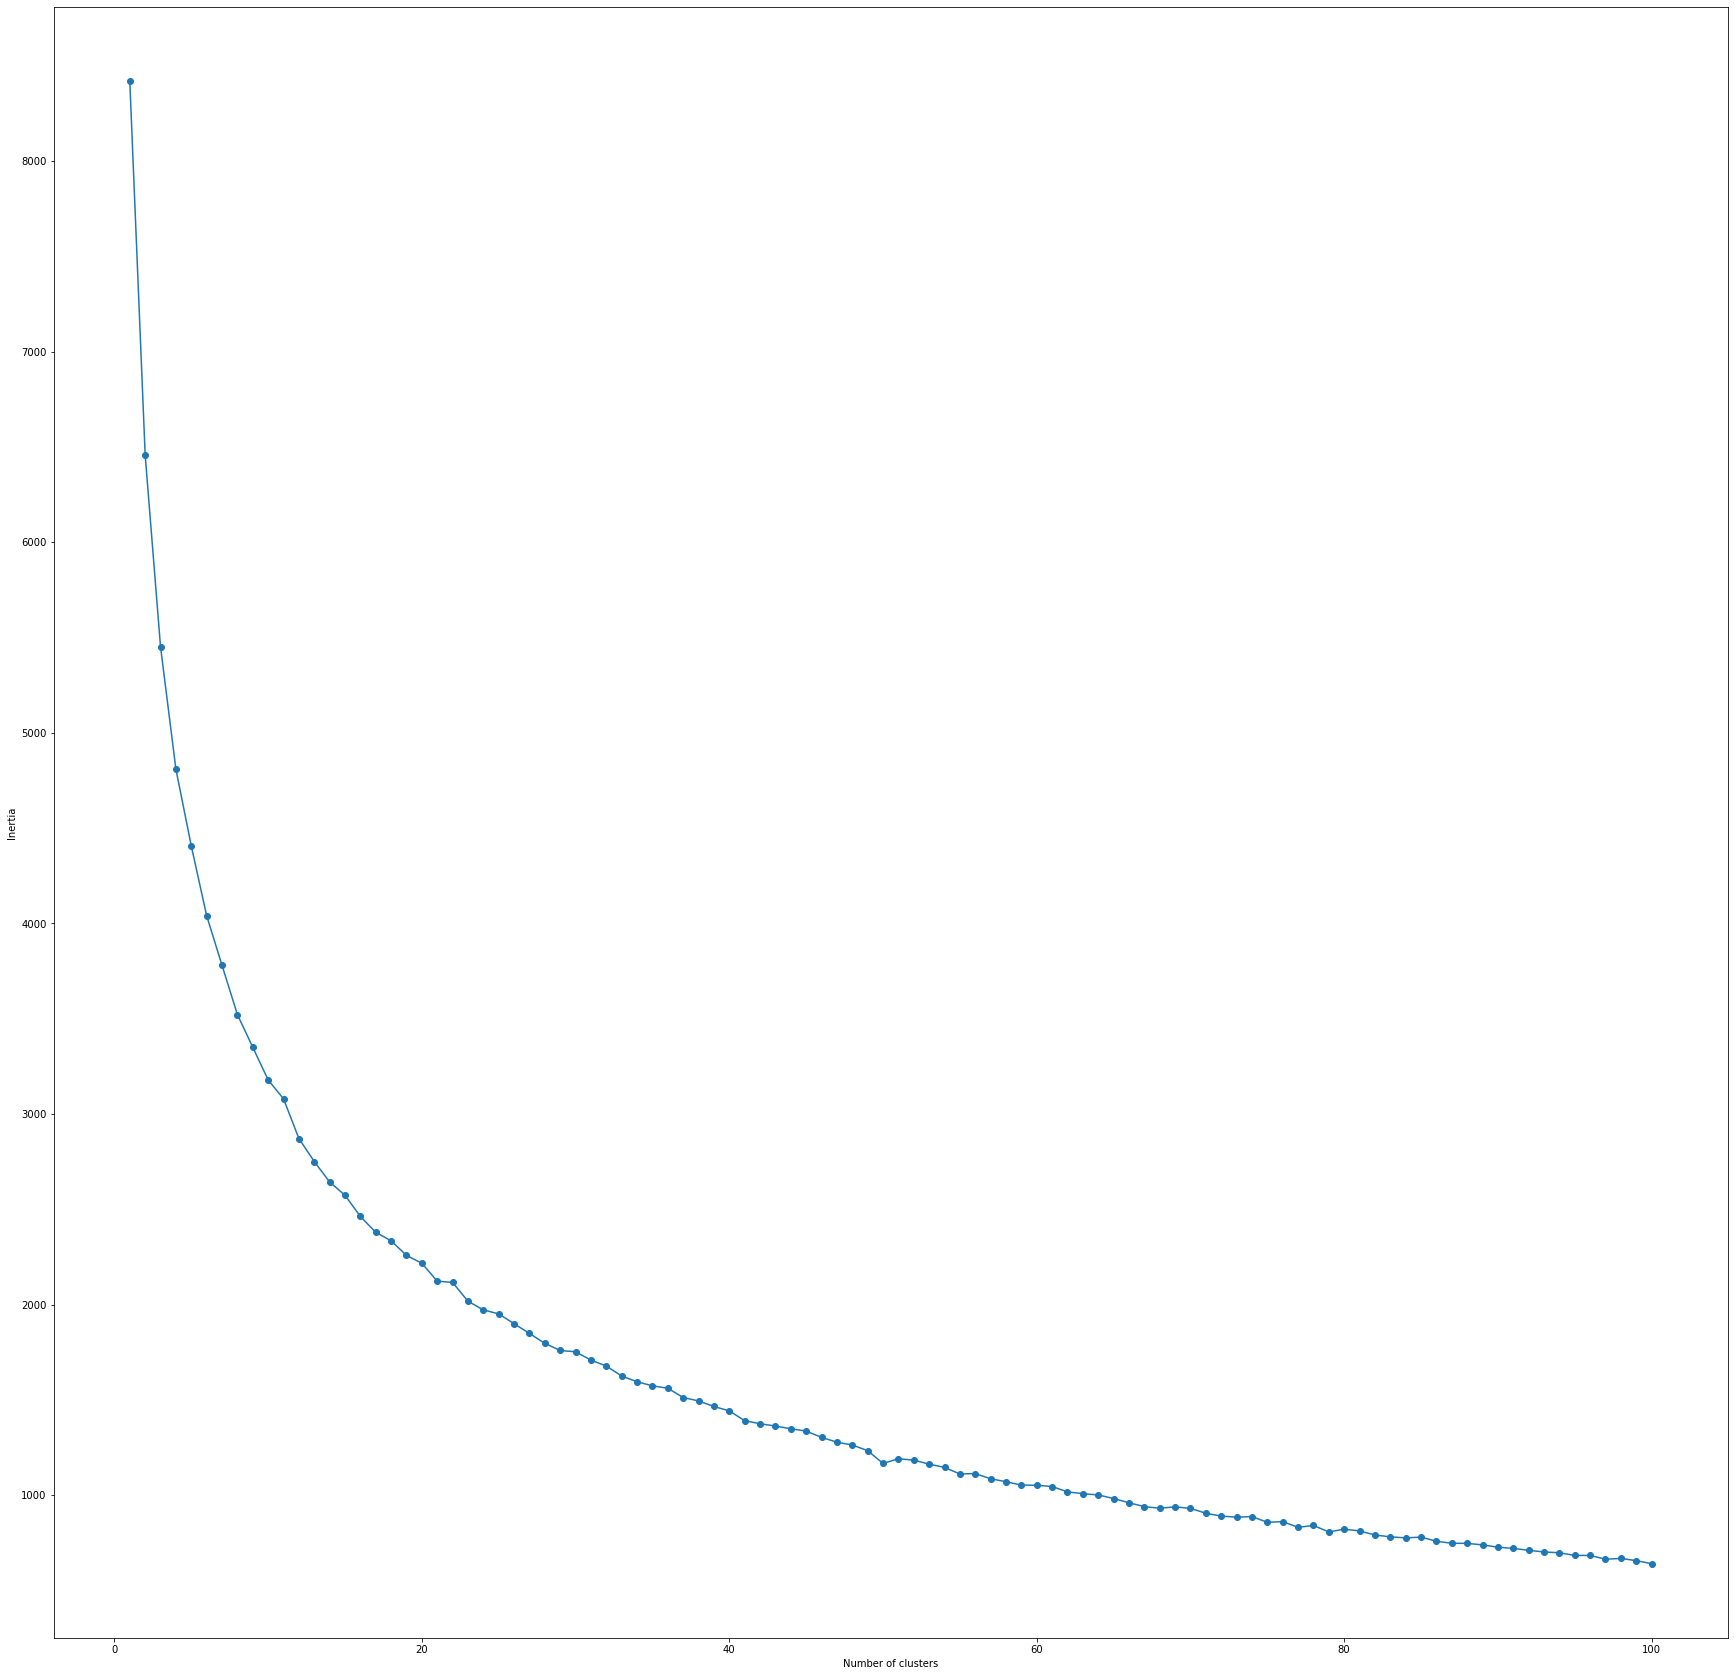

In [140]:
# first attempt at fitting K means to view change in Inertia

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(1, 101):
    km = KMeans(n_clusters=i)
    km.fit(X)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 101), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

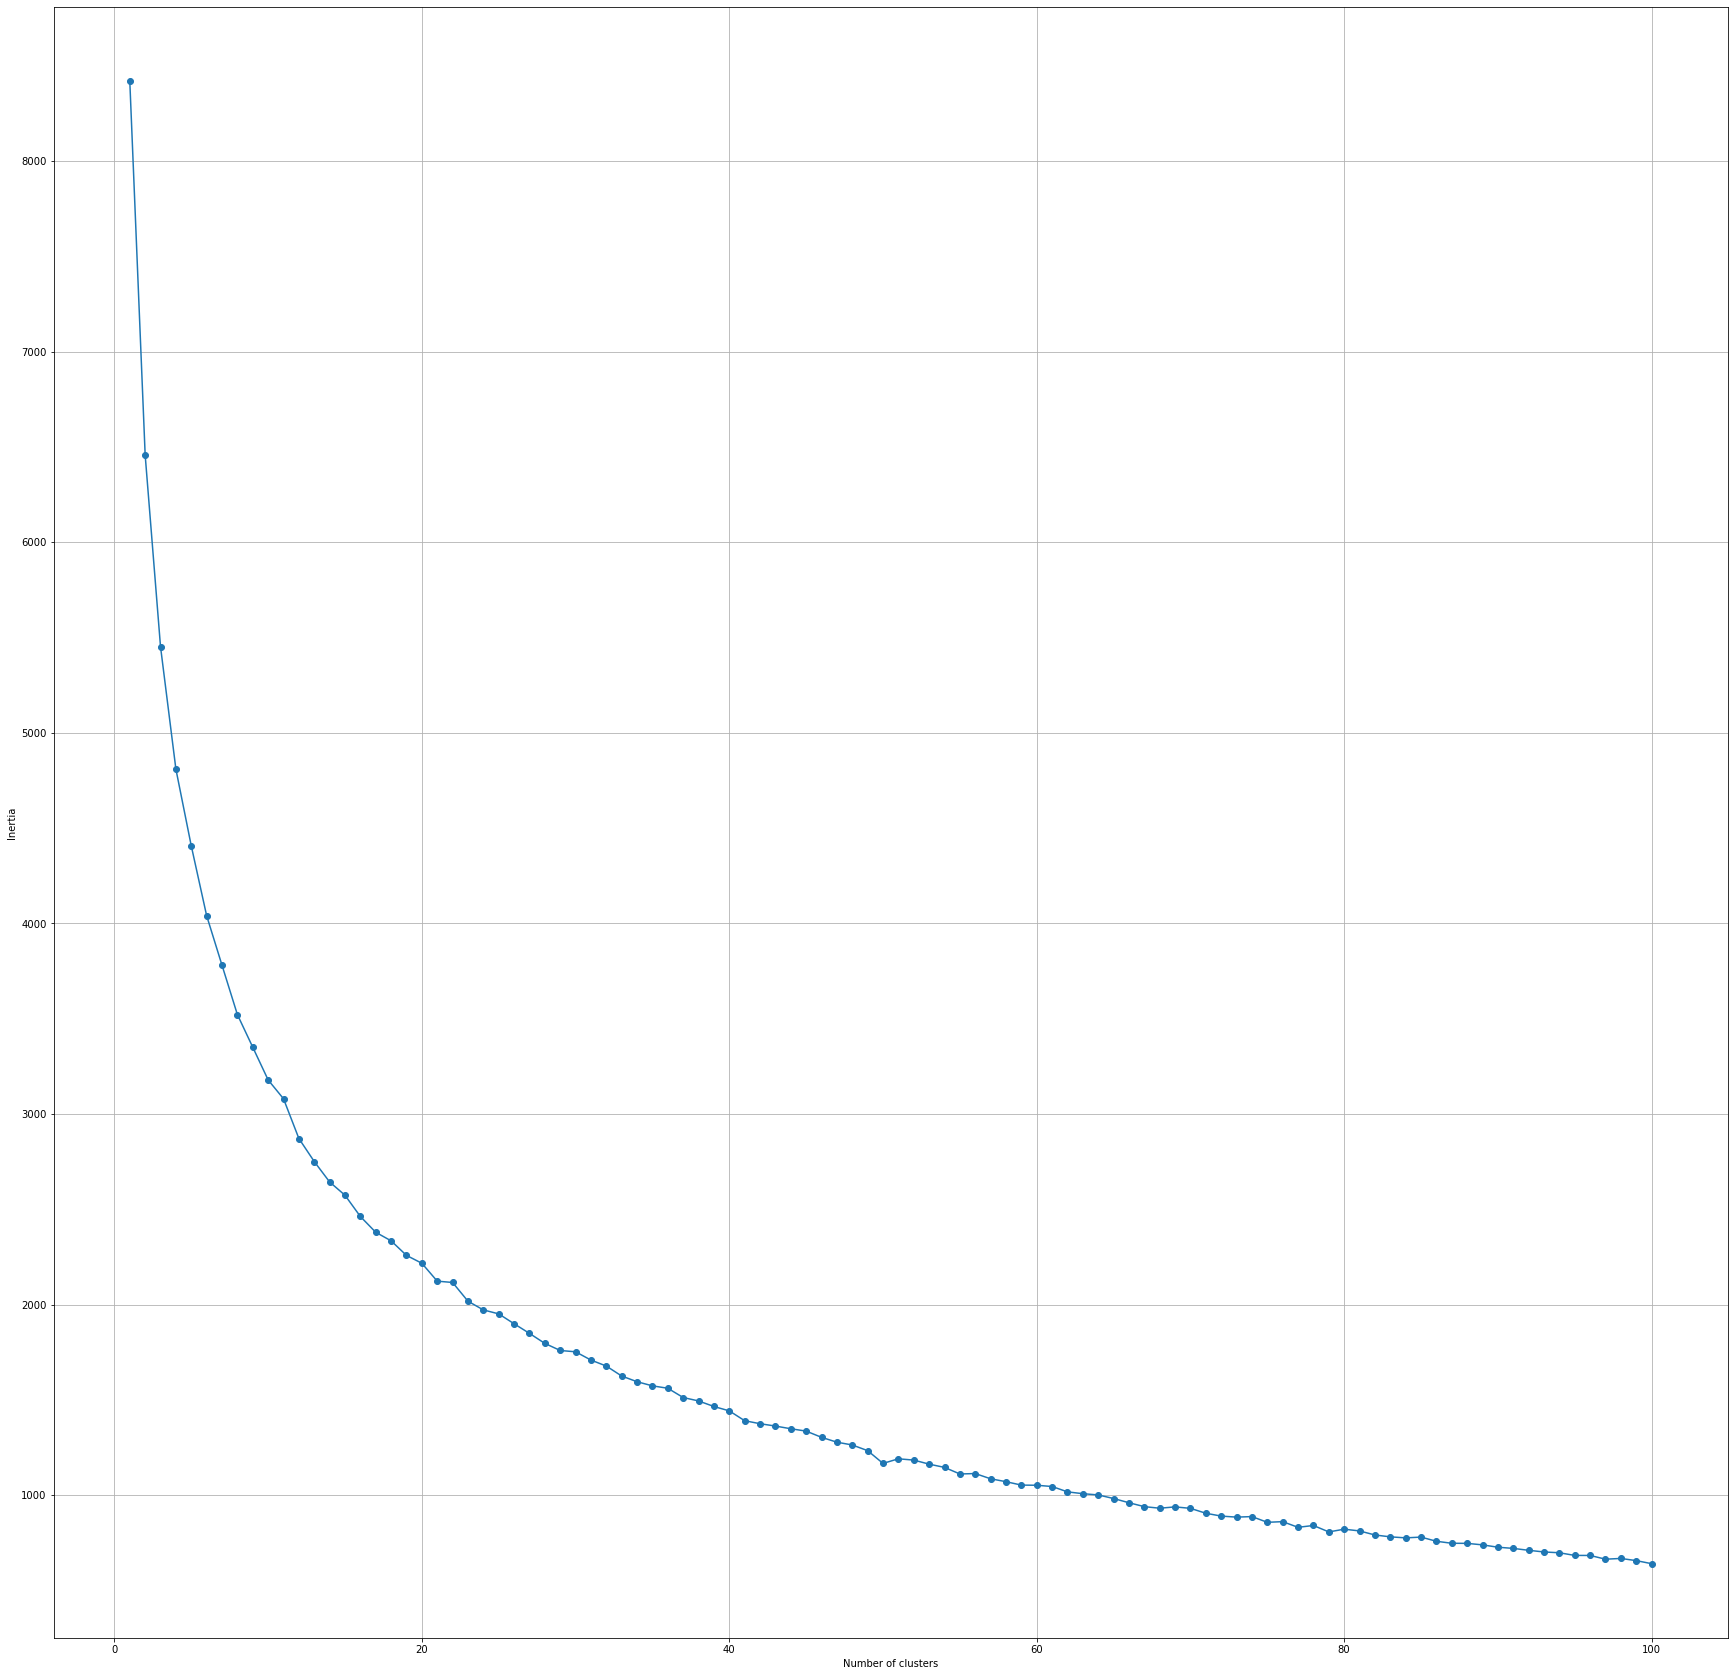

In [141]:
# vizualize change in inertia
plt.plot(range(1, 101), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.rcParams['figure.figsize'] = (30, 30)
plt.grid(b=True)
plt.show()

In [142]:
# modify this list to include the numbers of clusters you want to see
# I have *arbitrarily* chosen these values
range_n_clusters = [5, 8, 10, 12, 15, 18, 23]

For n_clusters = 5 The average silhouette_score is : 0.20514161798832947


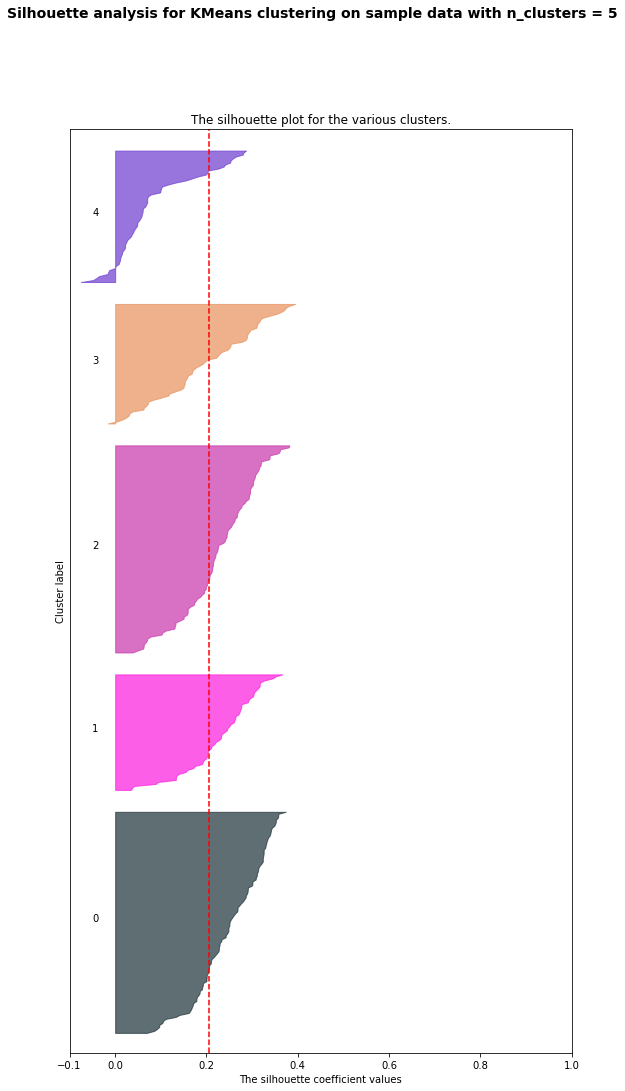

For n_clusters = 8 The average silhouette_score is : 0.21143766757266585


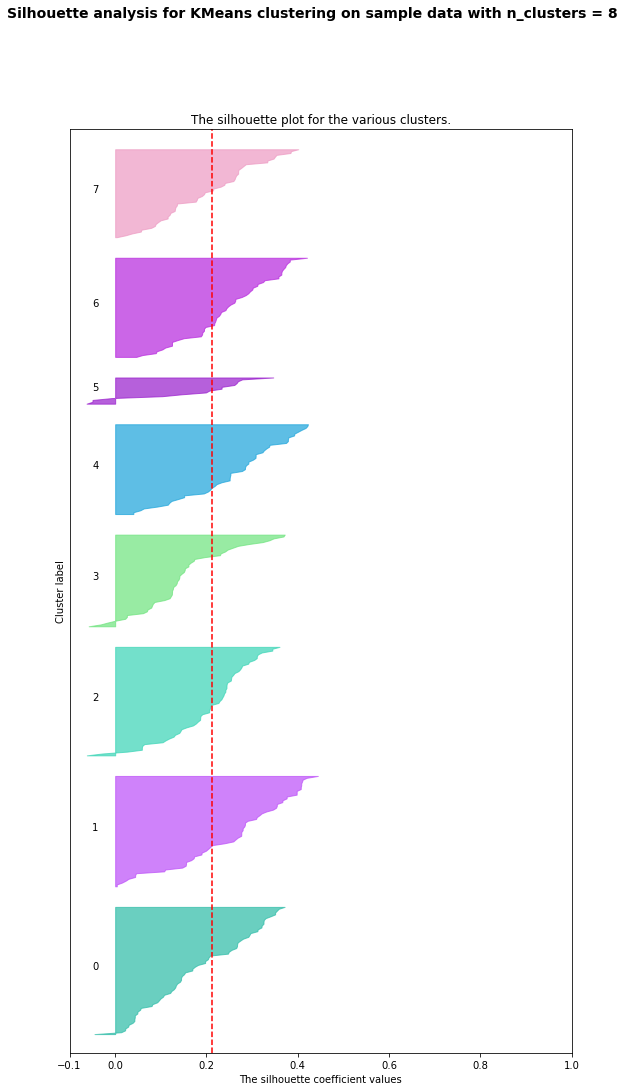

For n_clusters = 10 The average silhouette_score is : 0.21737655891272936


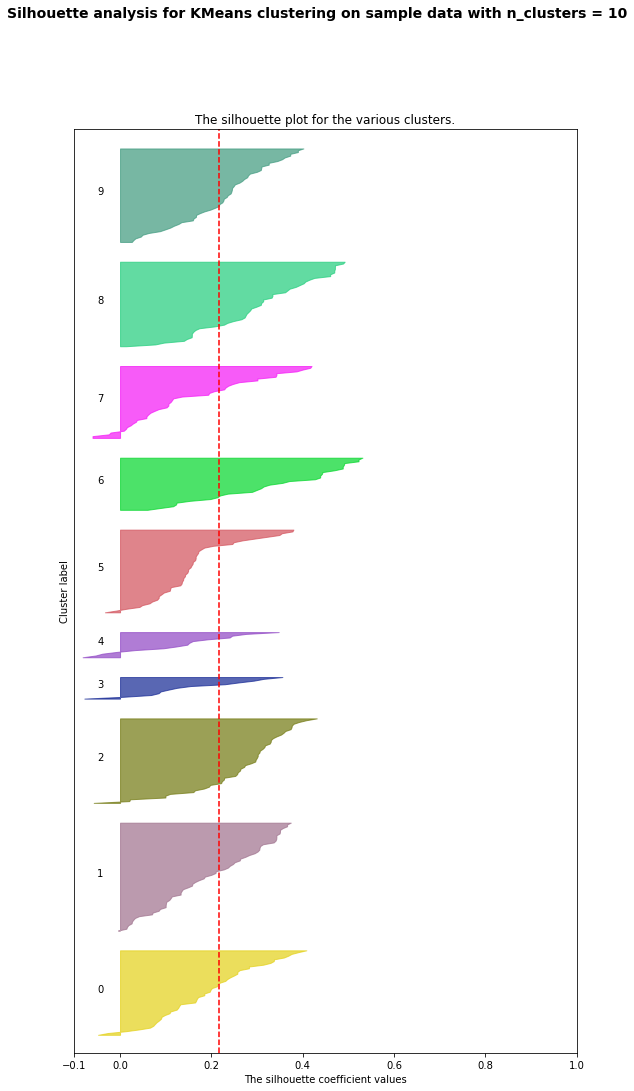

For n_clusters = 12 The average silhouette_score is : 0.2079400964353595


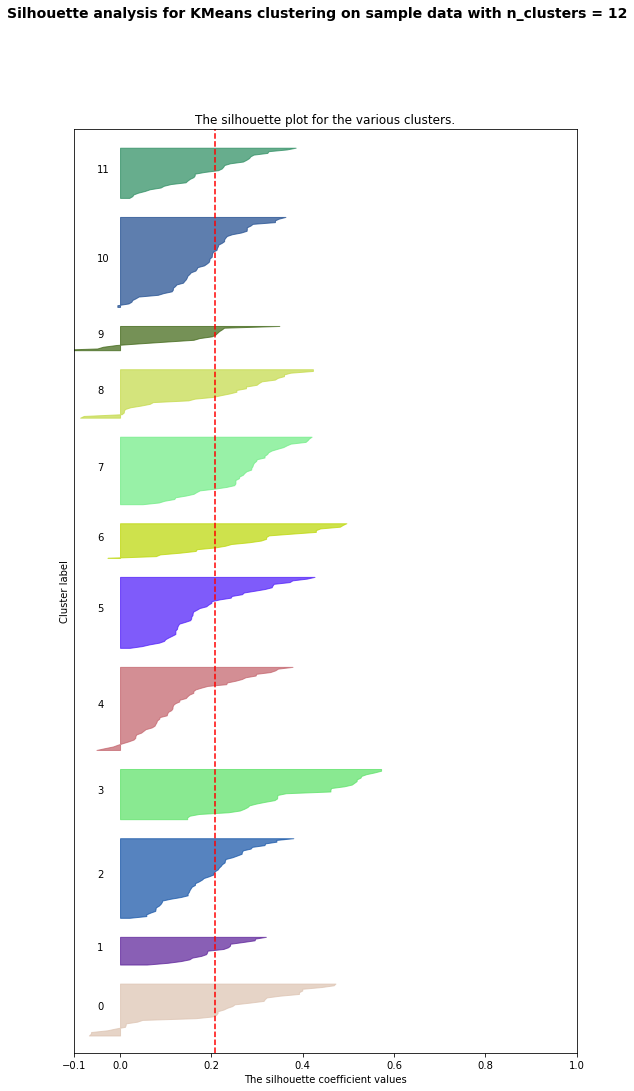

For n_clusters = 15 The average silhouette_score is : 0.21363347597074614


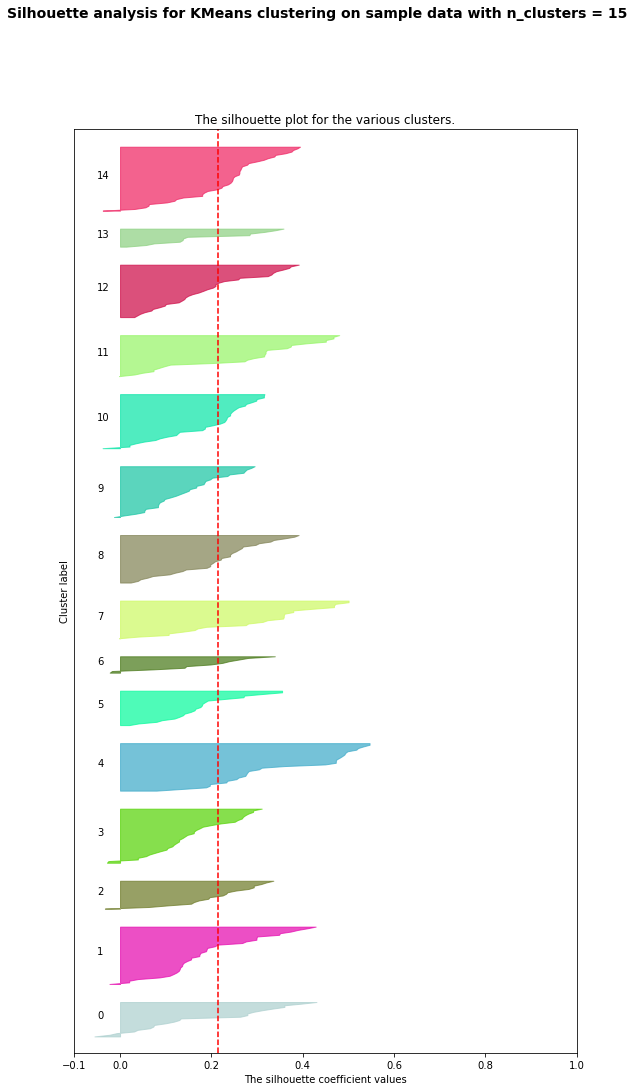

For n_clusters = 18 The average silhouette_score is : 0.21065936117672696


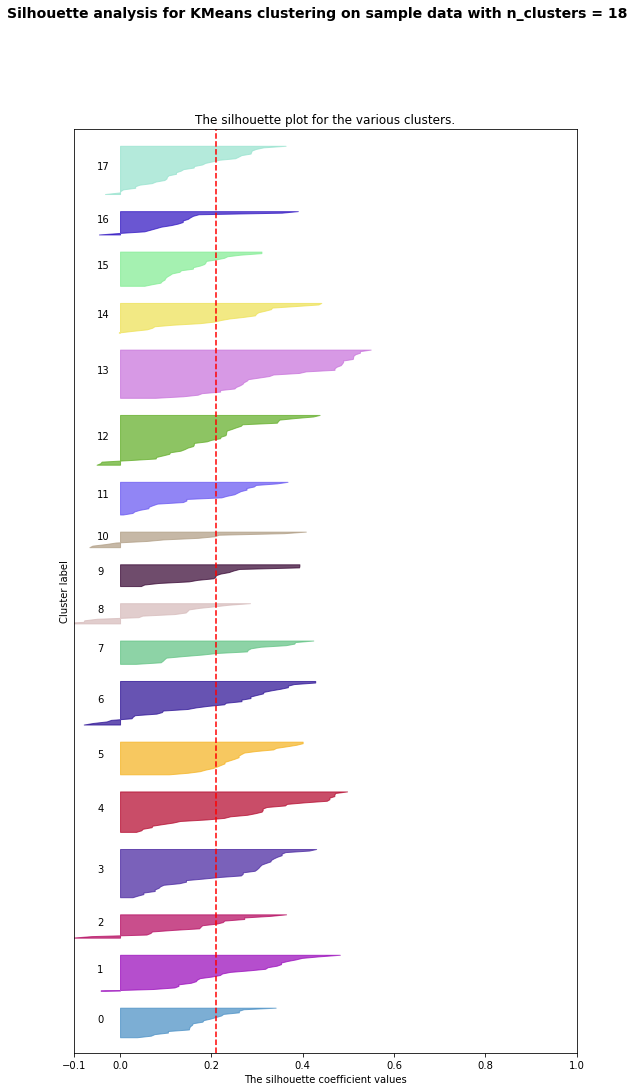

For n_clusters = 23 The average silhouette_score is : 0.21412558514864174


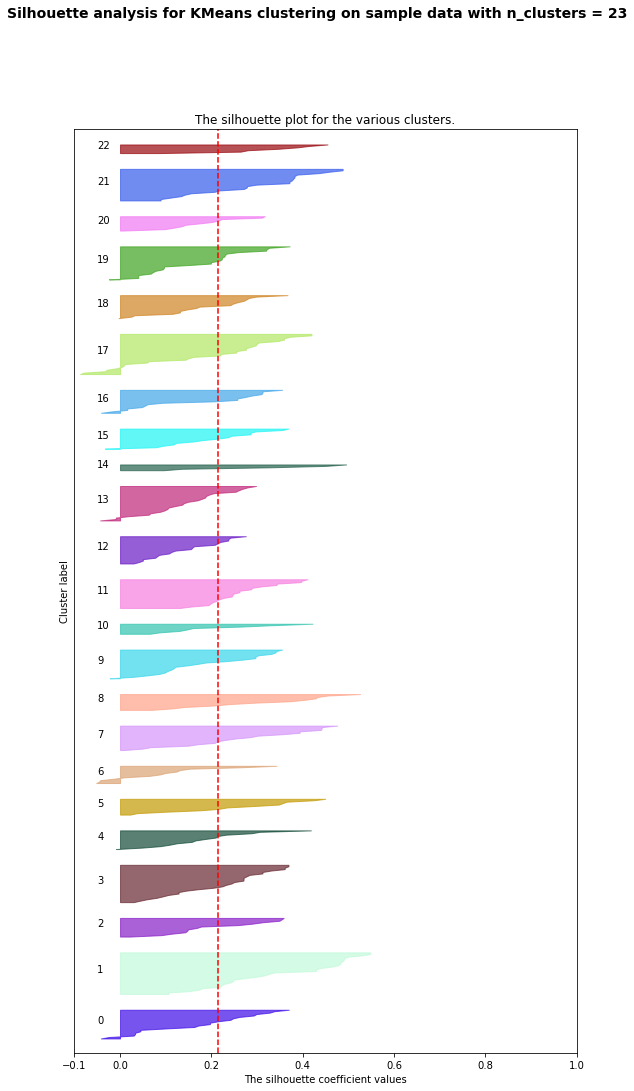

In [143]:
# modified from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import random

for n_clusters in range_n_clusters:
    # Create a subplot
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(9, 17)

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # select a random color for this cluster
        r = lambda: random.randint(0,255)
        color = '#%02X%02X%02X' % (r(),r(),r())
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [144]:
# set the number of clusters in the final model
my_n_clusters = 21

In [145]:
km = KMeans(n_clusters=my_n_clusters)
km.fit(X)

KMeans(n_clusters=21)

In [146]:
ci_path = '/Users/Charles/Desktop/ML/A3/img_small/'

# df = pd.read_csv(fpn_csv, usecols=[1, 2], encoding='ISO-8859-1')

c = []


for i in range(0, max(km.labels_)+1):
    print(" ")
#     print("* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * ")
    print("<h1>Cluster #" + str(i) + "</h1>")
#     print("* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * ")
    for j in range(0, len(km.labels_)):
        if km.labels_[j] == i:
#             txt = print(j) # call artist and title
#             plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=14); # orient text 
#             lookat = ci_path + str(j+2) + '_small.jpg' # location of image            
#             img_show = plt.imshow(io.imread(lookat)) # show image
#             plt.show() # plot image(?)
#             print(str(j+2) + '_small.jpg')

                print('<img src = "/Users/Charles/Desktop/ML/A3/img_small/' + str(j+2) + '_small.jpg">')
#             c.append('<img src = "/Users/Charles/Desktop/ML/A3/img_small/' + str(j+2) + '_small.jpg">')

# with open('your_file.txt', 'w') as f:
#     for listitem in c:
#         filehandle.write('%s\n' % listitem)

 
<h1>Cluster #0</h1>
<img src = "/Users/Charles/Desktop/ML/A3/img_small/17_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/20_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/24_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/40_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/48_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/60_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/65_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/114_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/116_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/132_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/138_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/144_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/149_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_small/152_small.jpg">
<img src = "/Users/Charles/Desktop/ML/A3/img_sm

## read and describe the metadata

## Image representation features

Create other features besides metadata.

In [57]:
ci_path = '/Users/Charles/Desktop/ML/A3/img_small/' # file path for cropped images for training
l_file = '/Users/Charles/Desktop/ML/A3/cluster_images.csv' # file path and file name for csv with labels
data = pd.read_csv(l_file, encoding='ISO-8859-1')

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of images are variable
dims = (150, 150) # resize all to uniform square, I wonder how it would process if I didn't resize

downscaled image shape: 
(411, 360)
image representation (first row of pixels): 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

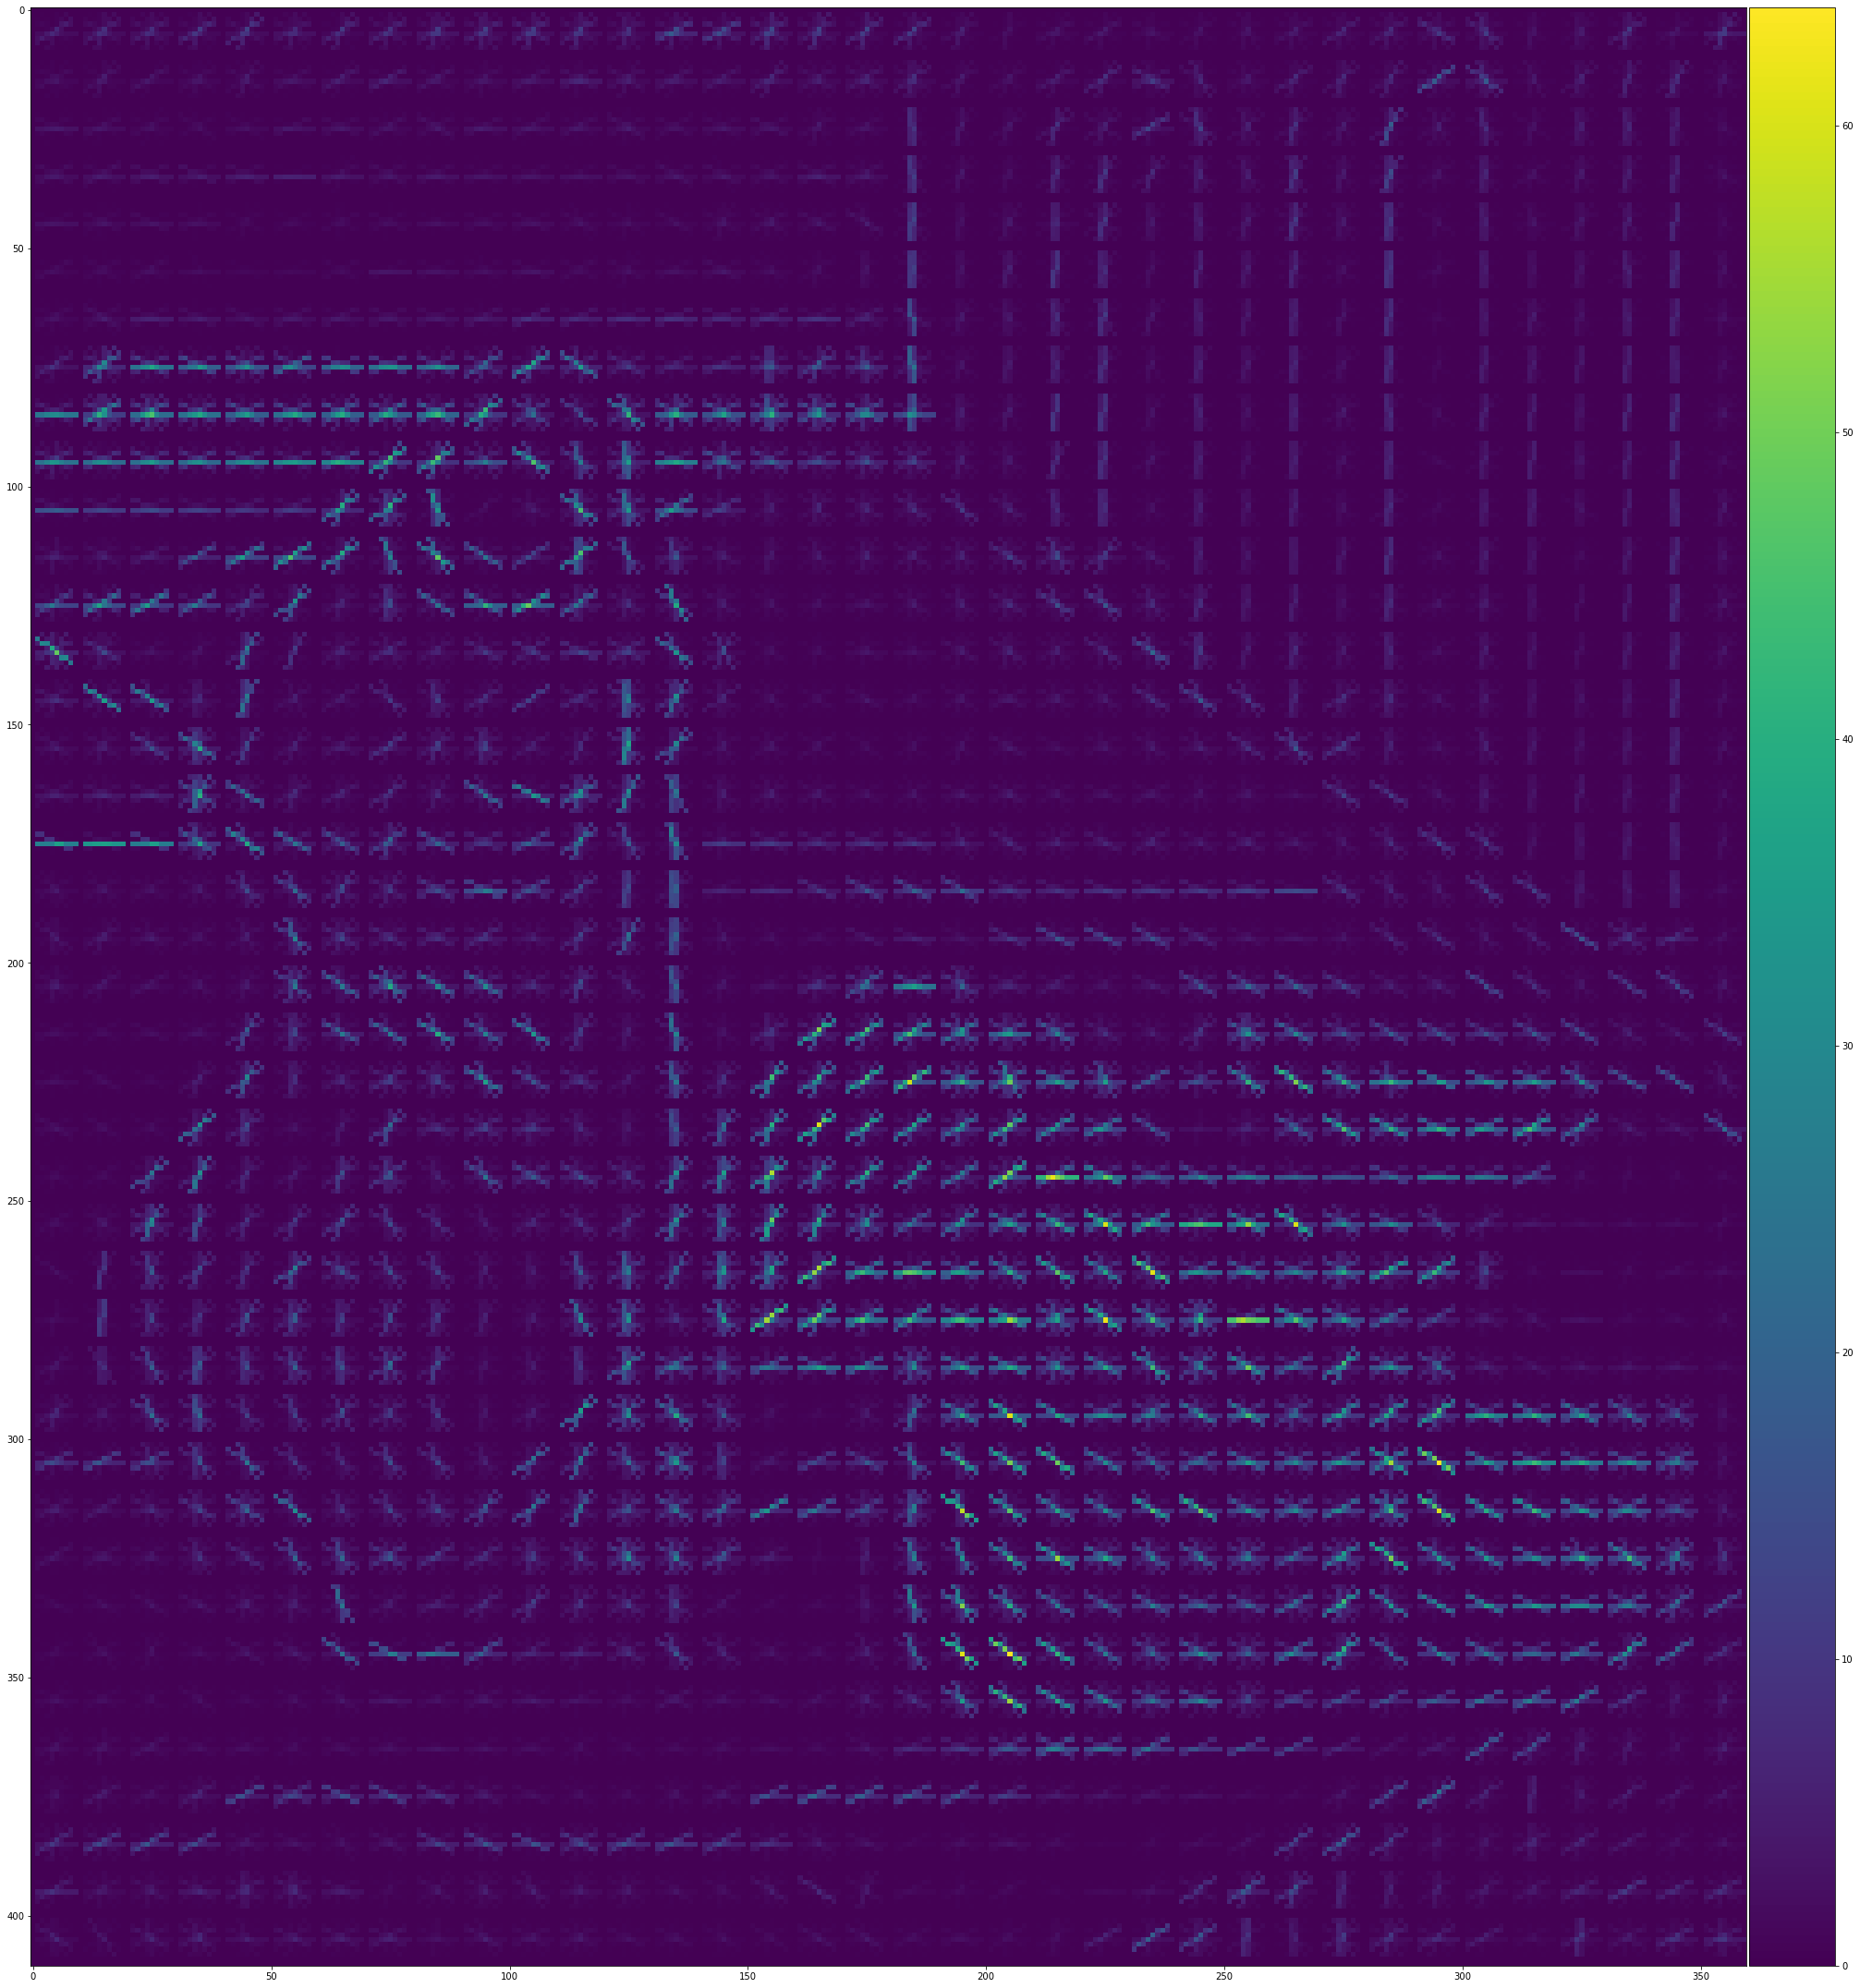

In [55]:
def img_hog(s_no_name, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + s_no_name + '_small.jpg' # define file path
#     img_raw = io.imread(imname, as_gray=True) # reads the image from file path
    img_raw = io.imread(imname) # reads the image from file path
    fd, fimg_hog = hog(img_raw, pixels_per_cell=(10, 10), 
                          cells_per_block=(1, 1), visualize=True, multichannel=True)
    final_image = np.array([fimg_hog])
    if imview==True:
        io.imshow(fimg_hog)
    warnings.filterwarnings('always')
    return fimg_hog


# test the function, look at input/output
test_image = img_hog('2', ci_path, True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

In [68]:
%%time

# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(metad_fn, images_fp, imview=False):
    plane_data = pd.read_csv(metad_fn, encoding='ISO-8859-1') # read in photograph labels
    
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
#     imnames_list = []
#     metadata_list = []

    for index, row in plane_data.iterrows():
        d = img_hog(str(row['s_no']), images_fp)
        features_list.append(d.flatten())
#         metadata_list.append(row[['artist', 'title', 'va', 'te', 'co', 'sh']])
#         imnames_list.append(row['s_no'])
    
#     full_list = hstack([features_list, metadata_list])
    # convert the lists to ndarrays
    X_feathog = np.array(features_list)
#     imgs = np.asarray(imnames_list)
#     print('Shape of original feature representation: ')
#     print(features.shape)

    # flatten the images ndarray to one row per image
#     X_feat_final = X_feathog.reshape((X_feathog.shape[0], -1))
    
    return X_feathog
    
#     print('Shape of flat feature representation: ')
#     print(features_flat.shape)

#     print('Shape of imgs: ')
#     print(imgs.shape)
    
# def extract_vector(path):
#     feature_list = []
    
#     for im in glob.glob(path):
        
#         im = cv2.imread(im)
#         im = cv2.resize(im, (224, 224))
#         img = preprocess_input(np.expand_dims(im.copy(), axis=0))
#         resnet_feature = my_new_model.predict(img)
#         resnet_feature_np = np.array(resnet_feature)
#         feature_list.append(resnet_feature_np.flatten())
    
#     X_feat = np.array(feature_list)
#     return X_feat



Wall time: 0 ns


C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
X3 = process_raw_data(l_file, ci_path, imview=False)

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [96]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(metad_fn, images_fp, imview=False):
    plane_data = pd.read_csv(metad_fn, encoding='ISO-8859-1') # read in photograph labels
    
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(img_hog(int(row['s_no']), images_fp))
        features.append(row['artist', 'title', 'va', 'te', 'co', 'sh'])
        imnames_list.append(row['s_no'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))
    
    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    print('Shape of imgs: ')
    print(imgs.shape)



In [ ]:
%%time
X_features, y_imgs,  = process_raw_data(l_file, ci_path, imview=False)

## create a subset of the columns you will use to fit KMeans

Here, I am **arbitrarily** choosing the seven [visual variables defined by Bertin](https://infovis-wiki.net/wiki/Visual_Variables). Variable descriptions [here](https://github.com/visualizedata/ml/blob/master/ML_assignment_3/option_2/contents-of-cluster_images.csv). 

You should choose the columns that you decide will best define the clusters. You may need to make transformations on existing variables. 

# KMeans

In [60]:
from sklearn.cluster import KMeans

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## plot inertia scores by number of clusters

In [ ]:
# first attempt at fitting K means to view change in Inertia'
# why do they call it inertia

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(1, 101):
    km = KMeans(n_clusters=i)
    # fitting X to some kind of normalized distribution
    # this means I have to pass quantitative measures of img rep features
    km.fit(X3)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 101), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.rcParams['figure.figsize'] = (15, 15)
plt.grid(b=True)
plt.show()

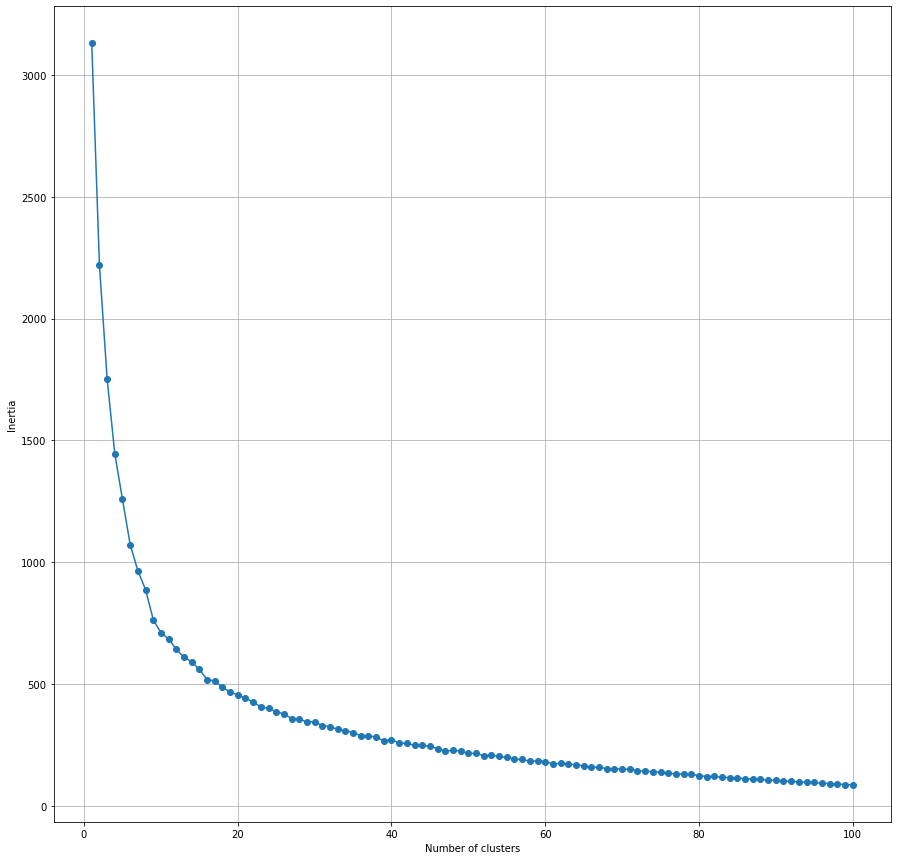

In [8]:
plt.plot(range(1, 101), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.rcParams['figure.figsize'] = (25, 25)
plt.grid(b=True)
plt.show()

## create silhouette plots to assess various specifications for `n_clusters` in `KMeans`

In [9]:
# modify this list to include the numbers of clusters you want to see
# I have *arbitrarily* chosen these values
range_n_clusters = [9]

For n_clusters = 9 The average silhouette_score is : 0.31092606263229755


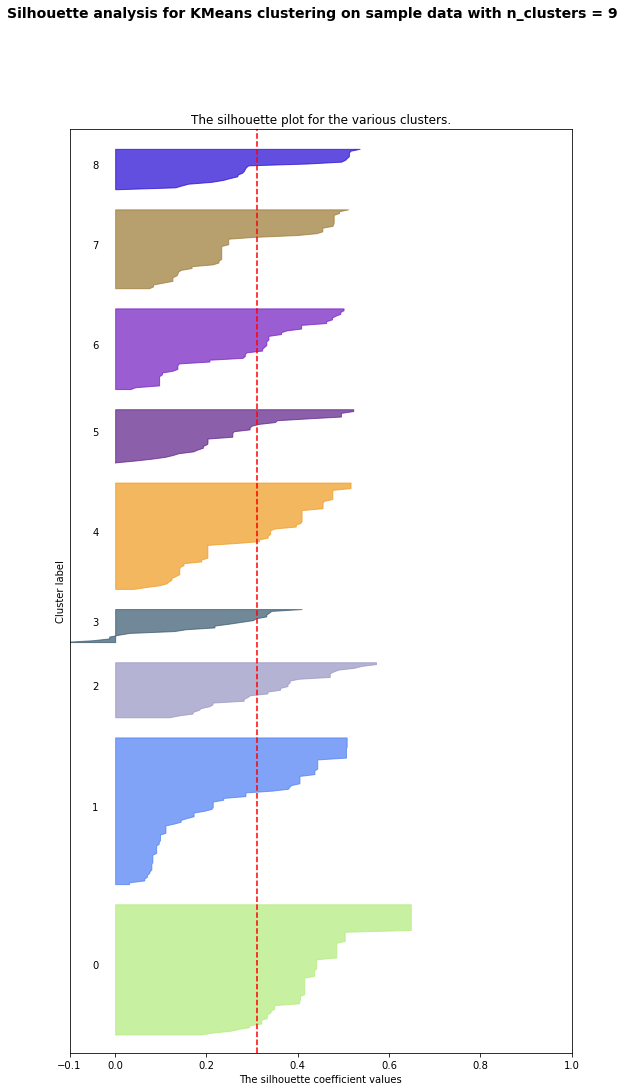

In [10]:
# modified from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import random

for n_clusters in range_n_clusters:
    # Create a subplot
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(9, 17)

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # select a random color for this cluster
        r = lambda: random.randint(0,255)
        color = '#%02X%02X%02X' % (r(),r(),r())
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

## final fit

After you have decided which features to include and the number of clusters you want, fit your final KMeans model. I have **arbitrarily** chosen 5. 

In [11]:
# set the number of clusters in the final model
my_n_clusters = 9

In [12]:
km = KMeans(n_clusters=my_n_clusters)
km.fit(X)

KMeans(n_clusters=9)

## look at results

The key to knowing if you have chosen the right features and clusters: looking at the images in each cluster and deciding whether they seem to belong together. You could extend this starter code to display the images in this notebook, or you may decide to use Python to write an html file/files to view the images by cluster.

In [63]:
ci_path = '/Users/Charles/Desktop/ML/A3/img_small/'

df = pd.read_csv(fpn_csv, usecols=[1, 2], encoding='ISO-8859-1')

for i in range(0, max(km.labels_)+1):
    print(" ")
    print("* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * ")
    print("Images in cluster #" + str(i))
    print("* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * ")
    for j in range(0, len(km.labels_)):
        if km.labels_[j] == i:
            txt = print(j) # call artist and title
            plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=14); # orient text 
            lookat = ci_path + str(j+2) + '_small.jpg' # location of image            
            img_show = plt.imshow(io.imread(lookat)) # show image
            plt.show() # plot image(?)
#             print(str(j+2) + '_small.jpg')

 
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Images in cluster #0
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


TypeError: iterrows() takes 1 positional argument but 2 were given